<a href="https://colab.research.google.com/github/CoWoGeo/PUS2022_CWolk/blob/main/HW6/HW6_RandomForestsDC_Take_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing Washington, DC Building Data

Following the paper "Examining the feasibility of using open data to benchmark building energy usage in cities: A data science and policy perspective" [Roth et al 2019](https://www.researchgate.net/publication/337074109_Examining_the_feasibility_of_using_open_data_to_benchmark_building_energy_usage_in_cities_A_data_science_and_policy_perspective), choose 2 cities in the dataset available through the paper's github repository https://github.com/Urban-Informatics-Lab/Open-Data-Benchmarking

This paper is an excellent example of reproducible research. 

I also created an example of using random forest classifier and regressors here https://github.com/fedhere/PUS2022_FBianco/blob/master/classdemo/COVID19LOS_featureExtractionRFexample.ipynb and there are links at the bottom of this notebook to useful functions and examples on the internet of applications of methods you will need to use.

1. Read the introduction to the paper and describe here (briefly) the goals of their analysis (and the analysis that you are about to reproduce). Max 200 words.
2. Choose 2 cities (any 2 cities except Seattle cause I am running some of the Seattle analysis below for guidance)
3. For each of the 2 cities reproduce their analysis by 

  3.1 gathering the original data from their repository (see below for Seattle example)

  3.2 clean the data according to their data preparation scheme, including one-hot-encoding categorical variables, except to impute missing data using KNearestNeighors instead of Gibbs sampling (see below)

  3.3 run a Random Forest (RF) Regressor to predict the total energy consumption.

  3.4 evaluate the RF model performance by printing the R2 score (the default score in SKLearn RF) for training and test set (discuss)

  3.5 plot the features sorted by their importance and identify the most important features. are they consistent between the 2 cities? are they consistent with the paper's result?
4 compare the result for the 2 cities (discuss)

5. Extra credit: 

  5.1 modify the target variable to a binary variable choosing the median of the variable values as the the energy threshold and predict whether the value is higher or lower than the threshold
  5.2 Run a Random Forest Classifier to predict if an observation is in the upper 50% percentile or lower 50% percentile (above or below the median threshold)
  5.3 Measure the performance of the model on training and test data
  5.4 Measure the feature importance and assess if the important feature have changed (discuss)

In [2]:
import pandas as pd
import numpy as np

In [3]:
import pylab as plt

In [4]:
import seaborn as sns

In [5]:
# for imputing data
from sklearn.impute import KNNImputer

In [6]:
# for one-hot encoding
from sklearn.preprocessing import OneHotEncoder
# for train-test split
from sklearn.model_selection import train_test_split
# for random forests
from sklearn.ensemble import RandomForestRegressor

# Reading in DC Data

In [7]:
dc = pd.read_csv("https://github.com/Urban-Informatics-Lab/Open-Data-Benchmarking/raw/master/DC/2016%20Energy%20and%20Water%20Performance%20Benchmarking%20Results%20as%20of%2009-07-2017.csv")

# inspect the dataframe

In [8]:
print("there are (rows, columns) = ", (dc.shape), "in the dataframe")

there are (rows, columns) =  (2181, 36) in the dataframe


In [9]:
dc.describe()

,pm_pid,ward,year_built,tax_record_floor_area,reported_gross_floor_area,energy_star_score,total_ghg_emissions,total_ghg_emissions_intensity,water_use,electricity_use,natural_gas_use,fuel_use,district_water_use,latitude,longitude
count,1.574000e+03,1844.000000,2153.000000,2.181000e+03,1.521000e+03,1209.000000,1519.000000,1519.000000,1.311000e+03,1.482000e+03,1.087000e+03,6.600000e+01,1.700000e+01,1954.000000,1954.000000
mean,3.477316e+06,3.387202,1933.421273,2.009089e+05,1.876181e+05,61.207610,1397.998947,7.221922,5.582172e+04,3.041003e+06,6.745484e+04,1.133411e+06,-1.261140e+07,38.908558,-77.025736
std,1.151670e+06,1.996951,223.684123,2.447139e+05,2.431177e+05,27.486072,2790.536339,6.886701,6.498499e+05,6.584801e+06,2.975285e+05,2.171472e+06,9.224563e+07,0.025003,0.031201
min,2.214000e+03,1.000000,0.000000,9.171000e+03,5.982000e+03,1.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,2.097600e+03,-3.685268e+08,38.813539,-77.107478
25%,3.300369e+06,2.000000,1942.000000,7.044300e+04,6.960000e+04,42.000000,390.300000,4.800000,2.114100e+03,7.495754e+05,1.115681e+04,2.461230e+04,7.908049e+05,38.898739,-77.044005
50%,3.617946e+06,2.000000,1969.000000,1.213110e+05,1.194700e+05,69.000000,755.400000,6.300000,4.160100e+03,1.656484e+06,2.791756e+04,1.952242e+05,5.512830e+06,38.905369,-77.031106
75%,4.066820e+06,5.000000,1997.000000,2.488440e+05,2.332170e+05,84.000000,1565.150000,7.900000,7.286700e+03,3.491451e+06,5.286096e+04,1.371327e+06,1.457592e+07,38.922848,-77.009371
max,5.939893e+06,8.000000,2017.000000,3.997572e+06,5.634890e+06,100.000000,64992.500000,134.400000,1.929391e+07,1.661020e+08,7.269109e+06,1.275372e+07,3.101497e+07,38.984554,-76.914972


# TASK 1 Clean the data 
*follow closely the second paragraph of Section 4 DATA. Name each step you do accordingly to the description in the paragraf*

Summary of that paragraph:

* Removed irrelevant building-identifying features such as address
*    Removed features w/ missing values for >40% of buildings in dataset because otherwise those will be imputed and bias the results.
*    Eliminated buildings w/ missing site EUI to avoid imputing values for dependent variable
*    Imputed data for remaining missing variables by generating multiple imputations by Gibbs sampling using classification and regression trees (I think this is a later step in the homework.)
*    Authors note that the data is extremely heterogeneous within and between datasets in terms of building counts and building sizes. This is partly due to local mandates, inclusion of government buildings, and smaller buildings opting in in some places. They note that "some models are better able to handle less data than others."

In [10]:
# summarize the number of rows with missing values for each column
for c in dc.columns:
  
  # count number of rows with missing values
  n_miss = dc[c].isnull().sum()
  perc = n_miss / dc.shape[0] * 100
  print('%s (%s):  Missing: %d (%.1f%%)' % (c, dc[c].dtype, 
                                                  n_miss, perc))


pid (object):  Missing: 0 (0.0%)
dc_real_pid (object):  Missing: 0 (0.0%)
pm_pid (float64):  Missing: 607 (27.8%)
property_name (object):  Missing: 660 (30.3%)
pm_parent_pid (object):  Missing: 660 (30.3%)
parent_property_name (object):  Missing: 660 (30.3%)
year_ending (object):  Missing: 0 (0.0%)
report_status (object):  Missing: 0 (0.0%)
address_of_record (object):  Missing: 0 (0.0%)
owner_of_record (object):  Missing: 0 (0.0%)
ward (float64):  Missing: 337 (15.5%)
reported_address (object):  Missing: 660 (30.3%)
city (object):  Missing: 0 (0.0%)
state (object):  Missing: 0 (0.0%)
postal_code (object):  Missing: 607 (27.8%)
year_built (float64):  Missing: 28 (1.3%)
primary_ptype_self (object):  Missing: 660 (30.3%)
primary_ptype_epa (object):  Missing: 660 (30.3%)
tax_record_floor_area (float64):  Missing: 0 (0.0%)
reported_gross_floor_area (float64):  Missing: 660 (30.3%)
energy_star_score (float64):  Missing: 972 (44.6%)
site_eui (object):  Missing: 674 (30.9%)
weather_norm_site_e

this data is so much worse than the final one fml

In [11]:
# dropping columns w/ over 40% missing
for c in dc.columns:
  
  # count number of rows with missing values
  n_miss = dc[c].isnull().sum()
  perc = n_miss / dc.shape[0] * 100
  if perc > 40:
    dc.drop(c, axis=1, inplace=True)

print("there are (rows, columns) = ", (dc.shape), "in the dataframe")

there are (rows, columns) =  (2181, 31) in the dataframe


In [12]:
dc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2181 entries, 0 to 2180
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   pid                            2181 non-null   object 
 1   dc_real_pid                    2181 non-null   object 
 2   pm_pid                         1574 non-null   float64
 3   property_name                  1521 non-null   object 
 4   pm_parent_pid                  1521 non-null   object 
 5   parent_property_name           1521 non-null   object 
 6   year_ending                    2181 non-null   object 
 7   report_status                  2181 non-null   object 
 8   address_of_record              2181 non-null   object 
 9   owner_of_record                2181 non-null   object 
 10  ward                           1844 non-null   float64
 11  reported_address               1521 non-null   object 
 12  city                           2181 non-null   o

In [13]:
# Dropping columns w/ building identifying data
dc = dc.drop(["pid", "dc_real_pid", "pm_pid", "property_name",
              "pm_parent_pid", "parent_property_name", "address_of_record",
              "reported_address"], axis=1)

Though the authors' [Data Glossary for DC](https://github.com/Urban-Informatics-Lab/Open-Data-Benchmarking/blob/master/DC/Data%20Glossary%20for%20Energy%20and%20Water%20Performance%20Benchmarking%20Data%20Results_2.pdf) says: "any properties with a [PM] parent property ID should be analyzed with other properties with the same Parent Property ID." Not sure how that factors in here, but I'm not writing a paper on this soooo 🤷

In [14]:
dc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2181 entries, 0 to 2180
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   year_ending                    2181 non-null   object 
 1   report_status                  2181 non-null   object 
 2   owner_of_record                2181 non-null   object 
 3   ward                           1844 non-null   float64
 4   city                           2181 non-null   object 
 5   state                          2181 non-null   object 
 6   postal_code                    1574 non-null   object 
 7   year_built                     2153 non-null   float64
 8   primary_ptype_self             1521 non-null   object 
 9   primary_ptype_epa              1521 non-null   object 
 10  tax_record_floor_area          2181 non-null   float64
 11  reported_gross_floor_area      1521 non-null   float64
 12  site_eui                       1507 non-null   o

In [15]:
# dropping city, state bc we know those are DC
dc = dc.drop(["city", "state"], axis=1)

In [16]:
dc["year_ending"].nunique()
print("there are (unique years) = ", dc["year_ending"].nunique())

there are (unique years) =  1


In [17]:
# dropping year ending because it's all the same
dc = dc.drop(["year_ending"], axis=1)

In [18]:
# what is report status?
dc["report_status"]

0                   In Compliance
1                   In Compliance
2                   In Compliance
3                   In Compliance
4                   In Compliance
                  ...            
2176    Data under review by DOEE
2177    Data under review by DOEE
2178    Data under review by DOEE
2179    Data under review by DOEE
2180    Data under review by DOEE
Name: report_status, Length: 2181, dtype: object

In [19]:
# dropping site EUI Nas because that's what the authors did
dc.dropna(subset=['site_eui'], inplace=True)

# TASK 2: transform input feature as needed
for example replace features with log features. Guide yourself with the text, the final dataset names, and also the code here https://github.com/Urban-Informatics-Lab/Open-Data-Benchmarking/blob/master/Lasso_RandomForest.Rmd

In the describe function below, I'm mostly looking at min, max, and standard deviation to get a sense of how big the ranges are and if there are columns that should have a log function or have very little variance.

In [20]:
dc.describe() #what should you look at in the result below?

,ward,year_built,tax_record_floor_area,reported_gross_floor_area,total_ghg_emissions,total_ghg_emissions_intensity,water_use,electricity_use,latitude,longitude
count,1172.000000,1504.000000,1.507000e+03,1.507000e+03,1505.000000,1505.000000,1.297000e+03,1.482000e+03,1445.000000,1445.000000
mean,3.098976,1940.269282,2.059051e+05,1.885880e+05,1411.003588,7.289103,5.638641e+04,3.041003e+06,38.908336,-77.026826
std,1.821805,168.202955,2.482438e+05,2.440136e+05,2800.217403,6.883176,6.533274e+05,6.584801e+06,0.024264,0.029891
min,1.000000,1000.000000,9.171000e+03,5.982000e+03,0.000000,0.000000,0.000000e+00,0.000000e+00,38.813539,-77.100527
25%,2.000000,1945.000000,7.142050e+04,7.000000e+04,395.900000,4.800000,2.166200e+03,7.495754e+05,38.898739,-77.044189
50%,2.000000,1970.000000,1.287720e+05,1.199629e+05,773.100000,6.300000,4.182800e+03,1.656484e+06,38.904631,-77.031575
75%,5.000000,1994.000000,2.580610e+05,2.349610e+05,1584.100000,8.000000,7.314600e+03,3.491451e+06,38.921322,-77.011535
max,8.000000,2017.000000,3.997572e+06,5.634890e+06,64992.500000,134.400000,1.929391e+07,1.661020e+08,38.983573,-76.919927


In [21]:
dc.info() #why is this helpful to print?

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1507 entries, 0 to 2180
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   report_status                  1507 non-null   object 
 1   owner_of_record                1507 non-null   object 
 2   ward                           1172 non-null   float64
 3   postal_code                    1507 non-null   object 
 4   year_built                     1504 non-null   float64
 5   primary_ptype_self             1507 non-null   object 
 6   primary_ptype_epa              1507 non-null   object 
 7   tax_record_floor_area          1507 non-null   float64
 8   reported_gross_floor_area      1507 non-null   float64
 9   site_eui                       1507 non-null   object 
 10  weather_norm_site_eui          1445 non-null   object 
 11  source_eui                     1507 non-null   object 
 12  weather_norm_source_eui        1445 non-null   o

In [22]:
dc["reported_gross_floor_area"].describe()

count    1.507000e+03
mean     1.885880e+05
std      2.440136e+05
min      5.982000e+03
25%      7.000000e+04
50%      1.199629e+05
75%      2.349610e+05
max      5.634890e+06
Name: reported_gross_floor_area, dtype: float64

In [23]:
dc["site_eui"].describe()

count     1507
unique     813
top       56.5
freq         8
Name: site_eui, dtype: object

In [24]:
dc["source_eui"]

0               175.9
1               229.8
2               215.6
3               147.7
4               206.3
            ...      
2167             13.8
2171                0
2178    Not Available
2179              0.1
2180             16.4
Name: source_eui, Length: 1507, dtype: object

Since some of the missing and 0 values for EUI are in the bottom, I pulled the tail of the data. It shows that at least some of these are university properties "(land only)" with missing or zero data in several columns. I think it's fine to drop them.

In [31]:
dc.tail(5)

,report_status,owner_of_record,ward,postal_code,year_built,primary_ptype_self,primary_ptype_epa,tax_record_floor_area,reported_gross_floor_area,site_eui,...,source_eui,weather_norm_source_eui,total_ghg_emissions,total_ghg_emissions_intensity,water_use,electricity_use,metered_areas_energy,latitude,longitude,BuildingEnergyUse
2167,Data under review by DOEE,HOWARD UNIVERSITY (LAND ONLY),1.0,20059,1979.0,College/University,Other,1095275.0,145000.0,13.1,...,13.8,13.8,101.0,0.7,14218.5,NaN,Whole Building,38.924094,-77.019154,6.278639
2171,Data under review by DOEE,HOWARD UNIVERSITY (LAND ONLY),1.0,20059,1960.0,College/University,College/University,1095275.0,101950.0,0.0,...,0,0,0.0,0.0,19928.1,NaN,Whole Building,38.924529,-77.020981,-inf
2178,Data under review by DOEE,HOWARD UNIVERSITY (LAND ONLY),1.0,20059,1956.0,College/University,College/University,162354.0,63367.0,NaN,...,Not Available,Not Available,0.0,0.0,1743.0,NaN,Whole Building,38.922096,-77.021542,NaN
2179,Data under review by DOEE,HOWARD UNIVERSITY (LAND ONLY),1.0,20059,1952.0,College/University,College/University,162354.0,98856.0,0.1,...,0.1,0.1,0.7,0.0,917.1,NaN,Whole Building,38.921564,-77.021498,3.995003
2180,Data under review by DOEE,THE HOWARD UNIVERSITY INC,1.0,20059,1994.0,Residence Hall/Dormitory,Residence Hall/Dormitory,190514.0,225000.0,15.6,...,16.4,16.4,186.9,0.8,13090.2,NaN,Whole Building,38.920882,-77.017807,6.545307


In [35]:
#removing all 0 values from site eui
dc = dc[(dc["site_eui"] > 0)]  

In [34]:
dc["site_eui"].describe()

count    1499.000000
mean       80.006471
std       145.094758
min         0.100000
25%        51.700000
50%        66.400000
75%        84.200000
max      5059.200000
Name: site_eui, dtype: float64

In [25]:
#realized I need to make site eui a float.
dc["site_eui"] = pd.to_numeric(dc["site_eui"], errors='coerce')

In [36]:
#adding column for building energy use
dc["BuildingEnergyUse"] = dc["reported_gross_floor_area"]*dc["site_eui"]

In [37]:
dc["BuildingEnergyUse"].describe()

count    1.499000e+03
mean     1.518428e+07
std      3.881919e+07
min      3.191900e+03
25%      4.516307e+06
50%      8.357310e+06
75%      1.597419e+07
max      7.832497e+08
Name: BuildingEnergyUse, dtype: float64

In [38]:
#making building energy use log
dc["BuildingEnergyUse"] = np.log10(dc["BuildingEnergyUse"])

In [39]:
dc["BuildingEnergyUse"].describe()

count    1499.000000
mean        6.907680
std         0.487948
min         3.504049
25%         6.654783
50%         6.922067
75%         7.203419
max         8.893900
Name: BuildingEnergyUse, dtype: float64

In [41]:
#don't need this anymore but leaving it anyway
np.isinf(dc["BuildingEnergyUse"])

0       False
1       False
2       False
3       False
4       False
        ...  
2163    False
2164    False
2167    False
2179    False
2180    False
Name: BuildingEnergyUse, Length: 1499, dtype: bool

## Throw away data where the **target** variable is missing

I will remove each row where I do not have the target variable. To do that I use `df.dropna()` and the subset argument of `df.dropna()` set to the name of the variable. The `how` should be set to "any" cause you want to drop the row where any values in the subset is NaN (this is a subset of one column, so it is obvious, but imagine if you were passing more than one column to the call `dropna()`

In [42]:
# one is the loneliest number
dc["BuildingEnergyUse"].isna().sum()

0

In [45]:
original_len = dc.shape[0]
dc.dropna(subset=["BuildingEnergyUse"], how="any", inplace=True)

print("I lost {:.2f}% of the data".format((1 - (dc.shape[0] / original_len)) * 100))

I lost 0.00% of the data


In [44]:
dc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1499 entries, 0 to 2180
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   report_status                  1499 non-null   object 
 1   owner_of_record                1499 non-null   object 
 2   ward                           1165 non-null   float64
 3   postal_code                    1499 non-null   object 
 4   year_built                     1496 non-null   float64
 5   primary_ptype_self             1499 non-null   object 
 6   primary_ptype_epa              1499 non-null   object 
 7   tax_record_floor_area          1499 non-null   float64
 8   reported_gross_floor_area      1499 non-null   float64
 9   site_eui                       1499 non-null   float64
 10  weather_norm_site_eui          1437 non-null   object 
 11  source_eui                     1499 non-null   object 
 12  weather_norm_source_eui        1437 non-null   o

In [46]:
# isolate the target variable first (endogenous)
y = dc["BuildingEnergyUse"].values

In [47]:
# and the input variables (exogenous)
X = dc.drop("BuildingEnergyUse", axis=1)

### separate categorical and numerical values

When I ran the separator, ward showed up in numeric because it is a number, so I converted it to object. All the EUIs were objects and ended up in categorical, so I converted them to numeric.

In [53]:
X["weather_norm_site_eui"] = pd.to_numeric(X["weather_norm_site_eui"], errors='coerce')

In [54]:
X["source_eui"] = pd.to_numeric(X["source_eui"], errors = "coerce")
X["weather_norm_source_eui"] = pd.to_numeric(X["weather_norm_source_eui"], errors = "coerce")

In [55]:
X[["ward"]] = X[["ward"]].astype(object)

In [56]:
# I am giving you the solution but please take note of how one does this!
X_numeric_data = X.select_dtypes(include=[np.number])
X_categorical_data = X.select_dtypes(exclude=[np.number])

In [62]:
print("there are (rows, columns) = ", (X_numeric_data.shape), "in the dataframe")

there are (rows, columns) =  (1499, 13) in the dataframe


In [58]:
X_numeric_data.head() ## is there anything suspicious? anything thas is in fact **not** a numerical variable? that will depend on how you did in TASK 1

,year_built,tax_record_floor_area,reported_gross_floor_area,site_eui,weather_norm_site_eui,source_eui,weather_norm_source_eui,total_ghg_emissions,total_ghg_emissions_intensity,water_use,electricity_use,latitude,longitude
0,1959.0,63227.0,65000.0,101.3,102.7,175.9,174.9,482.9,7.4,6963.5,633043.8,38.963597,-77.033848
1,1997.0,251557.0,257943.0,73.2,73.2,229.8,229.8,2164.4,8.4,8490.0,5531486.0,38.897849,-77.029872
2,1964.0,330550.0,223218.0,87.8,89.0,215.6,215.0,1852.2,8.3,8749.1,3863003.0,38.904056,-77.037973
3,1969.0,256839.0,213067.0,47.0,46.4,147.7,145.8,1249.2,5.9,5393.8,2936445.0,38.902189,-77.041238
4,1975.0,370000.0,381518.0,65.7,65.7,206.3,206.3,2874.1,7.5,10422.6,7345290.0,38.904376,-77.046882


In [59]:
X_categorical_data.head(3)

,report_status,owner_of_record,ward,postal_code,primary_ptype_self,primary_ptype_epa,metered_areas_energy
0,In Compliance,AUBINOE ROCKVIEW LIMITED PARTNERSHP; VICTORY I...,4.0,20011,Multifamily Housing,Multifamily Housing,Whole Building
1,In Compliance,UNION INVESTMENT REAL ESTATE GMBH,2.0,20005,Office,Office,Whole Building
2,In Compliance,CESC 1101 17TH STREET LIMITED PARTNERSHIP,2.0,20036,Office,Office,Whole Building


In [63]:
print("there are (rows, columns) = ", (X_categorical_data.shape), "in the dataframe")

there are (rows, columns) =  (1499, 7) in the dataframe


## TASK 2.1: make a scatter plot to assess covariance of numerical variables

### IMPORTANT!! 

there are going to be some **very** collinear variable - zoom in and chek them out - what are they? You will need to remove variables that are _identical_, because you obviously do not want to imput the data twice in the model - it will not improve the model and it will impact the feature importance analysis.

What else looks like it should be removed? 

**Reason about it and explain your choices in the caption of the figure**



In [ ]:
# THIS TAKES A LOOOONG TIME! ~10 MINUTES ON COLAB FOR ME
# I deleted output by putting it in #, is that what you meant?
#sns.pairplot(X_numeric_data)

I didn't look at the plots as much this time around because a lot of the columns were the same as the ones I'd decided to delete for Chicago/first pass at DC. I did keep lat/long just to make it spicy this time.

It's interesting: this version of the DC data must have had the natural gas values added or fixed because I dropped it for having 50% missing above, but the other version of this data set still had it here. This set also doesn't have energy star score or total site energy kbtu.

In [ ]:
# checking if maybe I should have used this data? but it wouldn't import so too bad
#moredcdata = pd.read_csv("https://github.com/Urban-Informatics-Lab/Open-Data-Benchmarking/blob/master/DC/dc_energy_geocoded.csv")

Dr. Bianco and I talked about what to drop! I deleted ALL the EUI ones (including "weather-normalized") electricity use, gas use, and GHG measures because they are basically all redundant or intra-dependent measures of energy use. 

In [64]:
# which rows should you drop?
X_numeric_data.drop(["electricity_use", "site_eui", "weather_norm_site_eui", 
                     "source_eui", "weather_norm_source_eui", 
                     "total_ghg_emissions_intensity", "total_ghg_emissions"], 
                    axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [65]:
X_numeric_data.describe()

,year_built,tax_record_floor_area,reported_gross_floor_area,water_use,latitude,longitude
count,1496.000000,1.499000e+03,1.499000e+03,1.290000e+03,1437.000000,1437.000000
mean,1940.156417,2.056808e+05,1.892880e+05,5.667402e+04,38.908232,-77.026888
std,168.613546,2.477628e+05,2.444708e+05,6.550870e+05,0.024286,0.029941
min,1000.000000,9.171000e+03,5.982000e+03,0.000000e+00,38.813539,-77.100527
25%,1945.750000,7.129800e+04,7.044300e+04,2.181475e+03,38.898725,-77.044240
50%,1970.000000,1.287670e+05,1.205730e+05,4.193100e+03,38.904564,-77.031591
75%,1994.000000,2.583795e+05,2.351780e+05,7.332225e+03,38.920967,-77.011669
max,2017.000000,3.997572e+06,5.634890e+06,1.929391e+07,38.983573,-76.919927


In [67]:
# this does not have to be identical to my output as you may have dropped different variables
print("there are (rows, columns) = ", X_numeric_data.shape, "in the numerical variables")

there are (rows, columns) =  (1499, 6) in the numerical variables


As they do in the original research https://github.com/Urban-Informatics-Lab/Open-Data-Benchmarking/blob/master/Lasso_RandomForest.Rmd we should transform some variables into their log values 

their original code (which is in R not in python!) is
```
x_seattle$log_total_area=log(x_seattle$gross_floor_area_total_SF)
x_seattle$log_parking_area=log(x_seattle$gross_floor_area_parking_SF)
x_seattle$log_bldg_area=log(x_seattle$gross_floor_area_building_SF)
x_seattle$log_area_1=log(x_seattle$gross_floor_area_property_type_first_SF)

```
the names are a bit different


In [68]:
# note: recheck missing values 
# this is important: after I apply the log function to some variables cause log(0) = -infinity
print("there are {} missing or infinity values in the numerical data".format(X_numeric_data.isnull().sum().sum()))

there are 336 missing or infinity values in the numerical data


In [66]:
# translated to python
X_numeric_data["tax_record_floor_area"] = np.log10(X_numeric_data["tax_record_floor_area"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [69]:
X_numeric_data["reported_gross_floor_area"] = np.log10(X_numeric_data["reported_gross_floor_area"])
X_numeric_data["water_use"] = np.log10(X_numeric_data["water_use"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [70]:
print("number of infinite values:", (np.isinf(X_numeric_data)).sum().sum())

number of infinite values: 2


check what happened to missing values: they may have grown! because  log(0) = -infinity - fix infinities replacing them with NaN 

(in in https://github.com/Urban-Informatics-Lab/Open-Data-Benchmarking/blob/master/Lasso_RandomForest.Rmd they had replaced them with 0 but I object to that)

In [71]:
# this has to return 0 now
X_numeric_data.replace(-np.inf, np.nan, inplace=True)
print("number of infinite values:", (np.isinf(X_numeric_data)).sum().sum())

number of infinite values: 0


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [72]:
print("the numerical data contains (rows, columns) = ", X_numeric_data.shape)
print("there are {} missing values in the numerical data".format(X_numeric_data.isnull().sum().sum()))

the numerical data contains (rows, columns) =  (1499, 6)
there are 338 missing values in the numerical data


In [73]:
#the missing data is in water use, lat, and long
X_numeric_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1499 entries, 0 to 2180
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   year_built                 1496 non-null   float64
 1   tax_record_floor_area      1499 non-null   float64
 2   reported_gross_floor_area  1499 non-null   float64
 3   water_use                  1288 non-null   float64
 4   latitude                   1437 non-null   float64
 5   longitude                  1437 non-null   float64
dtypes: float64(6)
memory usage: 82.0 KB



you can use `KNNImputer` on the numerical variables, but KNNImputer would fail on categorical variables so you are left with NaNs on categorical variables, which you then need to drop before you run the Random Forest


You can impute separately the numerical and categorical variables, the numerical ones with KNNImputer and the categorical ones with SimpleImputer

## TASK 2.2 use Nearest Neighbor Imputer to impute missing values in numerical features

here we are deviating from the paper. NN imputation is simpler and more common, I think it may be more useful to you in general

In [74]:
imputer = KNNImputer()
Xn = imputer.fit_transform(X_numeric_data)
Xn

array([[1959.        ,    4.80090258,    4.81291336,    3.84282758,
          38.96359693,  -77.033848  ],
       [1997.        ,    5.40063641,    5.41152375,    3.92890769,
          38.89784861,  -77.02987163],
       [1964.        ,    5.51923716,    5.34872921,    3.94196338,
          38.90405585,  -77.03797318],
       ...,
       [1979.        ,    6.03952317,    5.161368  ,    4.15285378,
          38.924094  ,  -77.019154  ],
       [1952.        ,    5.21046299,    4.99500303,    2.96241669,
          38.921564  ,  -77.021498  ],
       [1994.        ,    5.2799269 ,    5.35218252,    4.11694628,
          38.920882  ,  -77.017807  ]])

In [75]:
#this was from me troubleshooting infinities
numeric_whatswrong = pd.DataFrame(Xn)

In [76]:
#this was from me troubleshooting infinities
numeric_whatswrong.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1499 entries, 0 to 1498
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1499 non-null   float64
 1   1       1499 non-null   float64
 2   2       1499 non-null   float64
 3   3       1499 non-null   float64
 4   4       1499 non-null   float64
 5   5       1499 non-null   float64
dtypes: float64(6)
memory usage: 70.4 KB


In [77]:
print("number of infinite values:", (np.isinf(numeric_whatswrong)).sum().sum())

number of infinite values: 0


In [78]:
#yay it works now
numeric_whatswrong.describe()

,0,1,2,3,4,5
count,1499.000000,1499.000000,1499.000000,1499.000000,1499.000000,1499.000000
mean,1940.251234,5.135362,5.107462,3.603135,38.908283,-77.026945
std,168.458022,0.389200,0.377456,0.611672,0.023906,0.029410
min,1000.000000,3.962417,3.776846,-0.221849,38.813539,-77.100527
25%,1946.000000,4.853077,4.847838,3.347211,38.898743,-77.043898
50%,1971.000000,5.109805,5.081250,3.625611,38.904615,-77.031487
75%,1994.000000,5.412258,5.371397,3.885996,38.920854,-77.012761
max,2017.000000,6.601796,6.750885,7.285420,38.983573,-76.919927


## TASK 2.3 Impute missing categorial variables

Ugh sooo many are missing now

In [79]:
print("there are {} missing  values in the categorical data".format(X_categorical_data.isna().sum().sum()))

there are 443 missing  values in the categorical data


In [80]:
X_categorical_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1499 entries, 0 to 2180
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   report_status         1499 non-null   object
 1   owner_of_record       1499 non-null   object
 2   ward                  1165 non-null   object
 3   postal_code           1499 non-null   object
 4   primary_ptype_self    1499 non-null   object
 5   primary_ptype_epa     1499 non-null   object
 6   metered_areas_energy  1390 non-null   object
dtypes: object(7)
memory usage: 93.7+ KB


I'm going to fill the missing metered_areas_energy with "None" because there are just enough missing that I'd be worried about imputing them without making the data worse.

In [81]:
# filling metered areas energy with None
X_categorical_data["metered_areas_energy"].fillna("None", inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [82]:
X_categorical_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1499 entries, 0 to 2180
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   report_status         1499 non-null   object
 1   owner_of_record       1499 non-null   object
 2   ward                  1165 non-null   object
 3   postal_code           1499 non-null   object
 4   primary_ptype_self    1499 non-null   object
 5   primary_ptype_epa     1499 non-null   object
 6   metered_areas_energy  1499 non-null   object
dtypes: object(7)
memory usage: 93.7+ KB


In [83]:
Xc_nostringz = X_categorical_data[["ward", "postal_code"]]

In [84]:
Xc_nostringz["ward"] = pd.to_numeric(Xc_nostringz["ward"], errors = "coerce")
Xc_nostringz["postal_code"] = pd.to_numeric(Xc_nostringz["postal_code"], errors = "coerce")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [85]:
imputer = KNNImputer(add_indicator=True, n_neighbors=3)
Xc_nostringz = imputer.fit_transform(Xc_nostringz)
Xc_nostringz

array([[4.0000e+00, 2.0011e+04, 0.0000e+00, 0.0000e+00],
       [2.0000e+00, 2.0005e+04, 0.0000e+00, 0.0000e+00],
       [2.0000e+00, 2.0036e+04, 0.0000e+00, 0.0000e+00],
       ...,
       [1.0000e+00, 2.0059e+04, 0.0000e+00, 0.0000e+00],
       [1.0000e+00, 2.0059e+04, 0.0000e+00, 0.0000e+00],
       [1.0000e+00, 2.0059e+04, 0.0000e+00, 0.0000e+00]])

In [86]:
Xc_nostringz = pd.DataFrame(Xc_nostringz)
Xc_nostringz.rename({0: "ward", 1: 'postal_code'}, axis=1, inplace=True)
Xc_nostringz.drop(columns=[2], inplace=True)

In [87]:
Xc_nostringz.drop(columns=[3], inplace=True)

In [88]:
Xc_nostringz

,ward,postal_code
0,4.0,20011.0
1,2.0,20005.0
2,2.0,20036.0
3,2.0,22202.0
4,2.0,20037.0
...,...,...
1494,5.0,20017.0
1495,5.0,20017.0
1496,1.0,20059.0
1497,1.0,20059.0


In [89]:
Xc_nostringz = Xc_nostringz.astype("int")

In [90]:
Xc_nostringz["ward"]

0       4
1       2
2       2
3       2
4       2
       ..
1494    5
1495    5
1496    1
1497    1
1498    1
Name: ward, Length: 1499, dtype: int64

Looking at this again, I see that there are many more postal codes than wards. But this might be good, since I have fewer possibilities in the missing values than the data I'm using to fill them in.

In [91]:
Xc_nostringz.nunique()

ward            8
postal_code    44
dtype: int64

In [92]:
Xc_nostringz.head()

,ward,postal_code
0,4,20011
1,2,20005
2,2,20036
3,2,22202
4,2,20037


In [93]:
Xc_nostringz[["ward"]] = Xc_nostringz[["ward"]].astype(object)
Xc_nostringz[["postal_code"]] = Xc_nostringz[["postal_code"]].astype(object)

In [94]:
X_cat = X_categorical_data.drop(["ward"], axis=1)

In [95]:
X_cat.reset_index()

,index,report_status,owner_of_record,postal_code,primary_ptype_self,primary_ptype_epa,metered_areas_energy
0,0,In Compliance,AUBINOE ROCKVIEW LIMITED PARTNERSHP; VICTORY I...,20011,Multifamily Housing,Multifamily Housing,Whole Building
1,1,In Compliance,UNION INVESTMENT REAL ESTATE GMBH,20005,Office,Office,Whole Building
2,2,In Compliance,CESC 1101 17TH STREET LIMITED PARTNERSHIP,20036,Office,Office,Whole Building
3,3,In Compliance,1776 K STREET ASSOCIATES & RIDDELL PARTNERS,22202,Office,Office,Whole Building
4,4,In Compliance,CESC 2101 L STREET LLC,20037,Office,Office,Whole Building
...,...,...,...,...,...,...,...
1494,2163,In Compliance,Monroe Street Market - Brookland Works,20017,Multifamily Housing,Multifamily Housing,Whole Building
1495,2164,In Compliance,Monroe Street Market - Cornerstone,20017,Multifamily Housing,Multifamily Housing,Whole Building
1496,2167,Data under review by DOEE,HOWARD UNIVERSITY (LAND ONLY),20059,College/University,Other,Whole Building
1497,2179,Data under review by DOEE,HOWARD UNIVERSITY (LAND ONLY),20059,College/University,College/University,Whole Building


In [96]:
X_cat.head()

,report_status,owner_of_record,postal_code,primary_ptype_self,primary_ptype_epa,metered_areas_energy
0,In Compliance,AUBINOE ROCKVIEW LIMITED PARTNERSHP; VICTORY I...,20011,Multifamily Housing,Multifamily Housing,Whole Building
1,In Compliance,UNION INVESTMENT REAL ESTATE GMBH,20005,Office,Office,Whole Building
2,In Compliance,CESC 1101 17TH STREET LIMITED PARTNERSHIP,20036,Office,Office,Whole Building
3,In Compliance,1776 K STREET ASSOCIATES & RIDDELL PARTNERS,22202,Office,Office,Whole Building
4,In Compliance,CESC 2101 L STREET LLC,20037,Office,Office,Whole Building


In [97]:
Xc = X_cat.join(Xc_nostringz, rsuffix="right")

In [98]:
#another way to do this, gave slightly different results originally
Xc2 = X_cat.merge(Xc_nostringz, right_index=True, left_index=True)

#Where Coryn was Stuck

Why did it only impute ~60 of my missing wards? Did the other ones not have enough info? Where did all those zip codes go?

# How Fed Fixed It
Tho we still don't know why it was either giving me 1507 rows with Nas for some of the wards and one column of zipcodes (though fewer Na wards than the original!) or giving me full rows but fewer than 1507 for everything.

In [99]:
Xc_nostringz.index = list(range(Xc_nostringz.shape[0]))
X_cat.index = list(range(Xc_nostringz.shape[0]))

In [100]:
X_cat = X_cat.join(Xc_nostringz, rsuffix="right")

In [101]:
X_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1499 entries, 0 to 1498
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   report_status         1499 non-null   object
 1   owner_of_record       1499 non-null   object
 2   postal_code           1499 non-null   object
 3   primary_ptype_self    1499 non-null   object
 4   primary_ptype_epa     1499 non-null   object
 5   metered_areas_energy  1499 non-null   object
 6   ward                  1499 non-null   object
 7   postal_coderight      1499 non-null   object
dtypes: object(8)
memory usage: 137.7+ KB


# TASK 3 One Hot Encode the Categorical Variables

Hint: Once you have done the fit and the transformation, which gives you the transformed data according to the new encoding, what you get is normally a sparse matrix. In principle there is an argument `sparse` to `OneHotEncoder` which should prevent this and give you a dense matrix, which is much easier to handle (consider asking me or looking up what is a sparse matrix!). That attribute did not work for me so once I applied the new encoding I converted the result to a dense matrix as 
`Xc = Xc.todense()`

Finally, you will need to use a specific method to get the new names of the variables. Its a method of your model (which I called ohe below) and you can find it in this page here https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [102]:
X_cat.describe()

,report_status,owner_of_record,postal_code,primary_ptype_self,primary_ptype_epa,metered_areas_energy,ward,postal_coderight
count,1499,1499,1499,1499,1499,1499,1499,1499
unique,2,1087,52,46,46,4,8,44
top,In Compliance,GOVERNMENT OF THE DISTRICT OF COLUMBIA DEPARTM...,20005,Office,Office,Whole Building,2,20005
freq,1432,197,142,502,494,1368,629,142


Ooops where I went wrong AGAIN was one hot encoding the original data, not the fixed data!

In [103]:
# One Hot Encoding
ohe = OneHotEncoder(sparse=False).fit(X_cat)
Xc = ohe.transform(X_cat)
Xc

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [104]:
#get the names of the features after the encoding is done
feature_name_cat = ohe.get_feature_names_out()
feature_name_cat

array(['report_status_Data under review by DOEE',
       'report_status_In Compliance',
       'owner_of_record_"11TH & G ST INVESTORS', ...,
       'postal_coderight_200171566', 'postal_coderight_200242459',
       'postal_coderight_200362103'], dtype=object)

In [105]:
Xc.shape

(1499, 1289)

# Task 4 recombine your numerical and categorical imput features and split your data into training and testing

In [106]:
Xn.shape

(1499, 6)

In [107]:
Xc.shape

(1499, 1289)

In [108]:
X = np.hstack([Xn, Xc])
X.shape

(1499, 1295)

In [109]:
print("The dataset has {} features (!!!)".format(X.shape[1]))

The dataset has 1295 features (!!!)


In [115]:
# make a train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=72)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1124, 1295), (375, 1295), (1124,), (375,))

Tbh I didn't mess with the train and random state settings this time because I need to move on with my life.

# TASK 5 run a random forest REGRESSION model

report the score on the training and test data and identify the most important features

In [116]:
#I tried a few different max depths here.
rf = RandomForestRegressor(max_depth=4)
rf.fit(X_train, y_train)
print("accuracy on training data {:.2}".format(rf.score(X_train, y_train)))

accuracy on training data 0.73


# Model Results and Analysis

In [117]:
print ("the model test accuracy is {:.2}".format(rf.score(X_test, y_test)))

the model test accuracy is 0.62


Oooh this one has a much worse test and training and test vs training performance than my Chicago one!

In [118]:
#this is how you see the importance of the features
rf.feature_importances_[:10]

array([3.74532648e-03, 4.00535057e-02, 7.39741813e-01, 1.83920898e-02,
       4.65920475e-03, 5.51248911e-03, 5.04546632e-04, 5.46372188e-04,
       0.00000000e+00, 0.00000000e+00])

In [119]:
# One thing I tried
#feature_names = list(X_train.columns.values)

In [120]:
# making updated array of feature/column names (numeric then categorical)
columns = np.concatenate([X_numeric_data.columns, feature_name_cat])
#columns

In [121]:
#creating an index of rankings of feature importances
sorted_idx = np.argsort(rf.feature_importances_)

In [122]:
sorted_column_names = columns[sorted_idx]

In [127]:
print("there are so many columns in this version!: {}".format(len(columns)))

there are so many columns in this version!: 1295


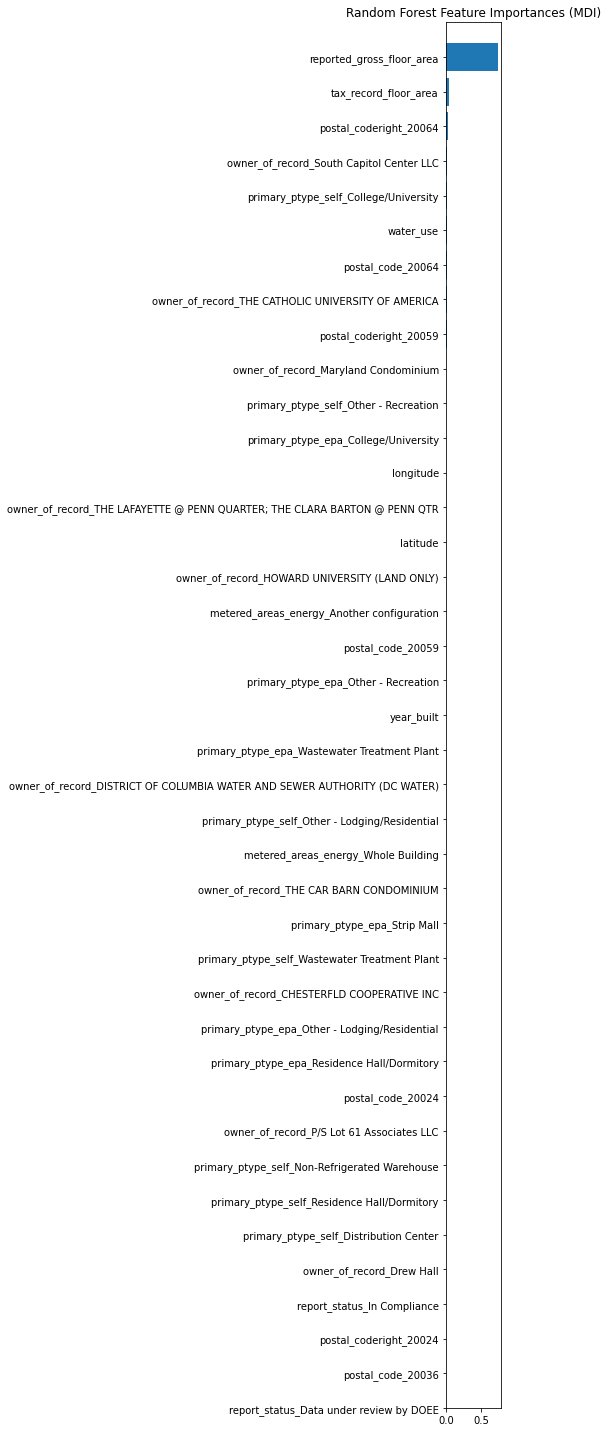

In [129]:
# plot the top ~50 features
y_ticks = np.arange(0, len(columns))
fig, ax = plt.subplots(figsize=(10,20))
ax.barh(y_ticks, rf.feature_importances_[sorted_idx])
ax.set_yticklabels(sorted_column_names)
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
ax.set_ylim(1255, len(columns))
plt.show()

## Conclusion

Like in Chicago and the authors' findings, building area is important! I realized I forgot to drop the additional zip code column but I will die if I spend more time on this homework. 20064 is high up here and I don't think it was on my other DC model. 20059 is somewhat high, though, too. That might be a sampling bias? Universities are above museums here, but you can see water use trying to appear from the mess of data.

# useful links and methods and functions I used: 

```df.dropna()``` to remove observation with missing variables

```df.drop(columns, axis=1)``` to remove features (columns)


```np.log10()``` and ```np.isinf()``` to convert to log space and find infinite values  

`np.hstack([X1, X2])` to concatenate two arrays


one hot encoder https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html and https://stackabuse.com/one-hot-encoding-in-python-with-pandas-and-scikit-learn/


KNN imputer https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html , https://www.analyticsvidhya.com/blog/2020/07/knnimputer-a-robust-way-to-impute-missing-values-using-scikit-learn/, and 
https://machinelearningmastery.com/knn-imputation-for-missing-values-in-machine-learning/  